<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#DecisionTreeRegressor" data-toc-modified-id="DecisionTreeRegressor-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>DecisionTreeRegressor</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li></ul></div>

#  Прогнозирование заказов такси

## Описание проекта 

**Заказчик**

Компания «Чётенькое такси».

**Задача**

Нужно построить модель, которая спрогнозирует количество заказов такси на следующий час.
Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

**Данные**

Исторические данные о заказах такси в аэропортах.

## Подготовка

In [1]:
# Загружаем бибилотеки.
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit

In [2]:
# Сохраняем путь к файлу на сервере Практикума.
server_path = '/datasets/taxi.csv' 


# Сохраняем путь к файлу на компьютере.
local_path = 'datasets/taxi.csv'   

try:                                                   # Пробуем найти данные по сетевому адресу,
    df = pd.read_csv(server_path) 
except:                                                # если не находим по сетевому, ищем по локальному.
    df = pd.read_csv(local_path) 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [4]:
# Проверяем данные.
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [5]:
# Изменяем тип данных, переобозначаем индексы. 
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')
df = df.set_index('datetime')
df.sort_index(inplace=True)
print(df.index.is_monotonic)

True


In [6]:
# Делаем ресемплирование. 
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


## Анализ

In [8]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


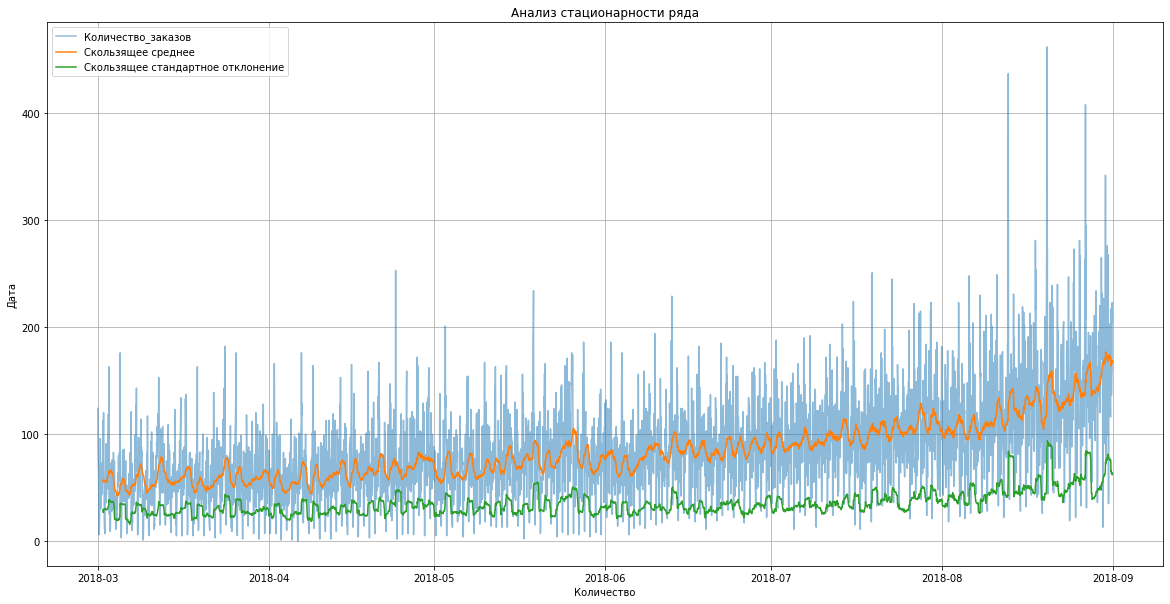

In [9]:
# График для анализа стационарности ряда.
plt.figure(figsize=(20, 10))
plt.plot(df.index, df['num_orders'], alpha=0.5)
plt.plot(df.index, df['num_orders'].rolling(24).mean())
plt.plot(df.index, df['num_orders'].rolling(24).std())
plt.xlabel('Количество')
plt.ylabel('Дата')
plt.grid(True)
plt.title('Анализ стационарности ряда')
plt.legend(['Количество_заказов', 'Скользящее среднее', 'Cкользящее стандартное отклонение'])
plt.show() 

In [10]:
decomposed = seasonal_decompose(df)

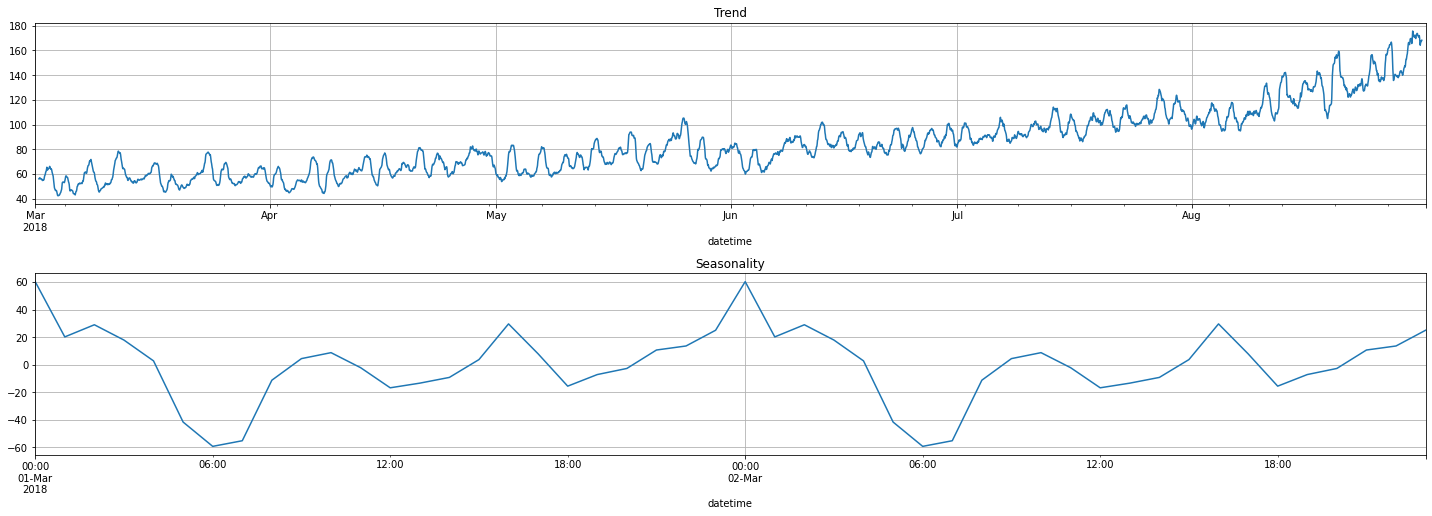

In [11]:
# График для анализа тренда и сезонности.
plt.figure(figsize=(20, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.grid(True)
plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-03-2'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.grid(True)
plt.tight_layout()

### Вывод

- Ряд не стационарный;
- В летние месяцы особенно к концу августа, возвращение из отпусков к началу учебного голда, среднее сильно возрастает как и колебание дисперсии;
- Также наблюдается сезонность в течении дня пик загрузки в 00.00 и спад в 06.00, второй ощутимый пик в районе 17.00.

## Обучение

In [12]:
# Функция для создания признаков, с параметрами data, max_lag, rolling_mean_size, которая:
#- добавляет день;
#- добавляет номер дня недели;
#- добавляет час;
#- добавляет отстающие значения;
#- добавляет скользящие среднее без учета текущего дня;
#- возвращает новый DF.

def make_features(data, max_lag, rolling_mean_size):
    data_new = data.copy()
    data_new['day'] = data.index.day
    data_new['dayofweek'] = data.index.dayofweek
    data_new['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data_new['lag_{}'.format(lag)] = data_new['num_orders'].shift(lag)

    data_new['rolling_mean'] = data_new['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data_new

In [13]:
# Применяем функцию
df_mf = make_features(df, 24, 24)

In [14]:
# Разбиваем на выборки на тестовую и тренировочную.
train, test = train_test_split(df_mf, shuffle=False, test_size=0.1)
train = train.dropna()

In [15]:
# Разбиваем на признаки.
features_train = train.drop(['num_orders'] , axis=1)
features_test = test.drop(['num_orders'] , axis=1)
target_train = train['num_orders']
target_test = test['num_orders']

In [16]:
# Проверяем разбиение.
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(3950, 28)
(3950,)
(442, 28)
(442,)


In [17]:
cbr_list = ['CBR']
dtr_list = ['DTR']
rfr_list = ['RFR']

### DecisionTreeRegressor

In [18]:
# Список параметров.
parameters = {'max_depth': [8, 14],
             'max_features':[4, 5]}

In [19]:
dtr = DecisionTreeRegressor(random_state=12345)

In [20]:
# Для ряда кросвалидация не подходим . 
tscv = TimeSeriesSplit(n_splits=5)

In [21]:
#Задаем параметры модели и поиска.
dtr_model = GridSearchCV(dtr, parameters, scoring='neg_root_mean_squared_error', cv=tscv, n_jobs=-1) 

In [22]:
%%time
dtr_model.fit(features_train, target_train)

CPU times: user 205 ms, sys: 918 µs, total: 205 ms
Wall time: 205 ms


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=DecisionTreeRegressor(random_state=12345), n_jobs=-1,
             param_grid={'max_depth': [8, 14], 'max_features': [4, 5]},
             scoring='neg_root_mean_squared_error')

In [23]:
# Параметры лучшей модели.
dtr_model.best_params_

{'max_depth': 8, 'max_features': 5}

In [24]:
%%time
pred_train = dtr_model.best_estimator_.predict(features_train) # Сохраняем RMSE На тренировочной выборке.
dtr_list.append(round(mean_squared_error(target_train, pred_train) ** 0.5, 2))

CPU times: user 0 ns, sys: 5.01 ms, total: 5.01 ms
Wall time: 3.61 ms


### RandomForestRegressor

In [25]:
# Список параметров.
parameters = {
    'n_estimators': [100, 200, 300]
}

In [26]:
rfr = RandomForestRegressor(max_depth=14, random_state=12345, max_features=5)

In [27]:
#Задаем параметры модели и поиска.
rfr_model = GridSearchCV(rfr, parameters, scoring='neg_root_mean_squared_error', cv=tscv, n_jobs=-1)

In [28]:
%%time
rfr_model.fit(features_train, target_train)

CPU times: user 18.3 s, sys: 188 ms, total: 18.5 s
Wall time: 18.5 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(max_depth=14, max_features=5,
                                             random_state=12345),
             n_jobs=-1, param_grid={'n_estimators': [100, 200, 300]},
             scoring='neg_root_mean_squared_error')

In [29]:
# Параметры лучшей модели.
rfr_model.best_params_

{'n_estimators': 300}

In [30]:
%%time
pred_train = rfr_model.best_estimator_.predict(features_train) # Сохраняем RMSE На тренировочной выборке.
rfr_list.append(round(mean_squared_error(target_train, pred_train) ** 0.5, 2))

CPU times: user 202 ms, sys: 0 ns, total: 202 ms
Wall time: 208 ms


### CatBoostRegressor

In [31]:
# Список параметров.
parameters = {'learning_rate': [0.1, 0.2],
             'depth':[8, 12]} 

In [32]:
cbr = CatBoostRegressor(loss_function="RMSE", iterations=150)

In [33]:
#Задаем параметры модели и поиска.
cbr_model = GridSearchCV(cbr, parameters, scoring='neg_root_mean_squared_error', cv=tscv, n_jobs=-1) 

In [34]:
%%time
cbr_model.fit(features_train, target_train, verbose=75)

0:	learn: 28.5578113	total: 62.9ms	remaining: 9.38s
75:	learn: 9.3777750	total: 818ms	remaining: 797ms
149:	learn: 5.3778564	total: 1.58s	remaining: 0us
0:	learn: 29.1258166	total: 17.3ms	remaining: 2.57s
75:	learn: 12.0278806	total: 901ms	remaining: 877ms
149:	learn: 7.9524446	total: 1.83s	remaining: 0us
0:	learn: 30.5365739	total: 22.4ms	remaining: 3.34s
75:	learn: 13.6324189	total: 1.08s	remaining: 1.05s
149:	learn: 10.3152349	total: 2.09s	remaining: 0us
0:	learn: 31.8732535	total: 24.6ms	remaining: 3.66s
75:	learn: 15.2660188	total: 1.1s	remaining: 1.07s
149:	learn: 11.8006332	total: 2.21s	remaining: 0us
0:	learn: 33.1798267	total: 25.8ms	remaining: 3.84s
75:	learn: 16.4992557	total: 1.15s	remaining: 1.12s
149:	learn: 13.2003273	total: 2.38s	remaining: 0us
0:	learn: 27.4702451	total: 11.9ms	remaining: 1.77s
75:	learn: 5.3447462	total: 785ms	remaining: 764ms
149:	learn: 1.5396529	total: 1.53s	remaining: 0us
0:	learn: 27.9846318	total: 15.3ms	remaining: 2.27s
75:	learn: 8.4166602	tot

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x7f04f92b0be0>,
             n_jobs=-1,
             param_grid={'depth': [8, 12], 'learning_rate': [0.1, 0.2]},
             scoring='neg_root_mean_squared_error')

In [35]:
# Параметры лучшей модели.
cbr_model.best_params_

{'depth': 8, 'learning_rate': 0.1}

In [36]:
%%time
pred_train = cbr_model.best_estimator_.predict(features_train) # Сохраняем RMSE На тренировочной выборке.
cbr_list.append(round(mean_squared_error(target_train, pred_train) ** 0.5, 2))

CPU times: user 3.81 ms, sys: 0 ns, total: 3.81 ms
Wall time: 3.52 ms


### Вывод

In [37]:
# Вывод по моделированию 
columns =[
    'model',
    'rmse_train'
]
data = []


data.append(cbr_list)
data.append(dtr_list)
data.append(rfr_list)

pd.DataFrame(data=data, columns=columns)

,model,rmse_train
0,CBR,14.82
1,DTR,21.32
2,RFR,10.27


**Выводы**
Лучший результат на тренировочной выборке RandomForestRegressor. В тестовой проверим эту модель.

## Тестирование

In [38]:
# Тестируем модель.
pred_test = rfr_model.best_estimator_.predict(features_test)
print('RMSE на тестовой выборке -', round(mean_squared_error(target_test, pred_test) ** 0.5, 2))

RMSE на тестовой выборке - 43.67


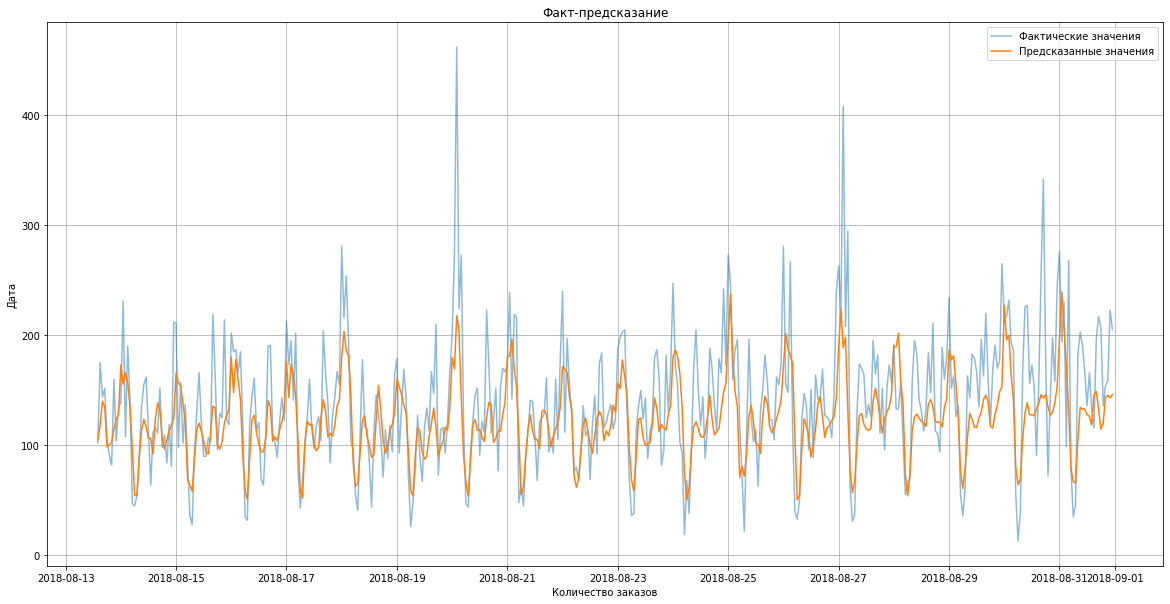

In [39]:
# График факт-предсказание.
plt.figure(figsize=(20, 10))
plt.plot(target_test.index, target_test, alpha=0.5)
plt.plot(target_test.index, pred_test)

plt.xlabel('Количество заказов')
plt.ylabel('Дата')
plt.grid(True)
plt.title('Факт-предсказание')
plt.legend(['Фактические значения', 'Предсказанные значения'])
plt.show() 

### Вывод

- Требуемый результат достигнут;
- Модели сильно переобучаються, т.к. обучение проиходит на оносительно стационраном участке, а прогноз делаеться на аномальном;
- Месяцы, фактор который, больше мешает чем помогает при обучении, была бы выборака за 2-3 года, это исправило бы ситуацию;
- Модель плохо предсказывает выбросы и старается усреднить ряд;
- Подбор гиперпараметров сильно не помогает, модели просто переобучаются, основной параеметр - это создание признаков.